# AirBnB data cleaning

## Notebook set-up

Assume we are preparing this data for a linear regression model. Based on our previous analysis of distributions and correlations, we now know what cleaning steps are needed to prepare this data for machine learning modeling.

In [1]:
from pathlib import Path

# PyPI imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import HistGradientBoostingRegressor

import gperdrizet_functions as funcs

pd.set_option('display.max_rows', 500)

## 1. Data loading

In [ ]:
data_df = pd.read_csv('https://raw.githubusercontent.com/4GeeksAcademy/data-preprocessing-project-tutorial/main/AB_NYC_2019.csv')
data_df.head().transpose()

,0,1,2,3,4
id,2539,2595,3647,3831,5022
name,Clean & quiet apt home by the park,Skylit Midtown Castle,THE VILLAGE OF HARLEM....NEW YORK !,Cozy Entire Floor of Brownstone,Entire Apt: Spacious Studio/Loft by central park
host_id,2787,2845,4632,4869,7192
host_name,John,Jennifer,Elisabeth,LisaRoxanne,Laura
neighbourhood_group,Brooklyn,Manhattan,Manhattan,Brooklyn,Manhattan
neighbourhood,Kensington,Midtown,Harlem,Clinton Hill,East Harlem
latitude,40.64749,40.75362,40.80902,40.68514,40.79851
longitude,-73.97237,-73.98377,-73.9419,-73.95976,-73.94399
room_type,Private room,Entire home/apt,Private room,Entire home/apt,Entire home/apt
price,149,225,150,89,80


In [3]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

We can see the same 48,895 listings with missing values in `reviews_per_month` and various data quality issues identified in our previous analysis. Now we'll systematically address these issues for modeling.

## 2. Feature selection

Select relevant features for modeling by removing non-predictive variables like IDs, names, and dates. We'll focus on features that showed meaningful relationships in our correlation analysis, preparing separate lists for numerical and categorical features for different processing steps.

In [ ]:
label = 'price'

features = [
    'latitude',
    'longitude',
    'minimum_nights',
    'number_of_reviews',
    'reviews_per_month',
    'calculated_host_listings_count',
    'availability_365',
    'neighbourhood_group',
    'room_type'
]

numerical_features = [
    'price',
    'latitude',
    'longitude',
    'minimum_nights',
    'number_of_reviews',
    'reviews_per_month',
    'calculated_host_listings_count',
    'availability_365'
]

nominal_features = ['neighbourhood_group','room_type']

data_df = data_df[numerical_features + nominal_features].copy()

**Result**: Selected 9 features for modeling:
- **Target variable**: `price` (what we want to predict)
- **Numerical features (7)**: Location coordinates, booking requirements, reviews, host activity, availability
- **Categorical features (2)**: `neighbourhood_group` and `room_type` (both showed significant relationships with price)
- **Excluded**: ID fields, names, specific neighborhoods (too many categories), and dates

## 3. Feature encoding

In [ ]:
encoded_datasets = {}

### 3.1. Ordinal encoding

Apply ordinal encoding to categorical features, converting them to integers (0, 1, 2, etc.). This approach assumes ordinal relationships between categories, which may not be appropriate for nominal features like neighbourhood_group and room_type, but we'll test its performance.

In [ ]:
ordinal_encoded_data_df = data_df.copy()

label_encoder = OrdinalEncoder()
ordinal_encoded_data_df[nominal_features] = label_encoder.fit_transform(ordinal_encoded_data_df[nominal_features])

encoded_datasets['Ordinal encoded'] = ordinal_encoded_data_df
ordinal_encoded_data_df[nominal_features].head().transpose()

,0,1,2,3,4
neighbourhood_group,1.0,2.0,2.0,1.0,2.0
room_type,1.0,0.0,1.0,0.0,0.0


### 3.2. One-hot encoding

Apply one-hot encoding to categorical features, creating binary columns for each category level. This approach treats categories as truly nominal (no assumed order) and is generally more appropriate for features like neighbourhood_group and room_type.

In [ ]:
one_hot_encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded_data = one_hot_encoder.fit_transform(data_df[nominal_features])
one_hot_features = one_hot_encoder.get_feature_names_out()
one_hot_encoded_data_df = pd.DataFrame(one_hot_encoded_data.astype(int), columns=one_hot_features)
one_hot_encoded_data_df = pd.concat([one_hot_encoded_data_df, data_df[numerical_features]], axis=1)
encoded_datasets['One-hot encoded'] = one_hot_encoded_data_df
one_hot_encoded_data_df[one_hot_features].head().transpose()

,0,1,2,3,4
neighbourhood_group_Bronx,0,0,0,0,0
neighbourhood_group_Brooklyn,1,0,0,1,0
neighbourhood_group_Manhattan,0,1,1,0,1
neighbourhood_group_Queens,0,0,0,0,0
neighbourhood_group_Staten Island,0,0,0,0,0
room_type_Entire home/apt,0,1,0,1,1
room_type_Private room,1,0,1,0,0
room_type_Shared room,0,0,0,0,0


### 3.3. Results

Compare the performance of label encoding vs one-hot encoding using both linear regression and gradient boosting models. This will help us determine which encoding method works better for our specific dataset and problem.

#### 3.3.1. Linear model

In [ ]:
linear_cross_val_results_df, linear_tukey_result = funcs.evaluate_datasets(
    LinearRegression(),
    encoded_datasets
)

ANOVA p-value: 0.093



#### 3.3.2. Tree model

In [ ]:
tree_cross_val_results_df, tree_tukey_result = funcs.evaluate_datasets(
    HistGradientBoostingRegressor(random_state=315),
    encoded_datasets
)

ANOVA p-value: 0.885



#### 3.3.3. Model comparison

Linear model:

         Multiple Comparison of Means - Tukey HSD, FWER=0.05         
     group1          group2     meandiff p-adj   lower  upper  reject
---------------------------------------------------------------------
One-hot encoded Ordinal encoded  -0.0121 0.0926 -0.0263 0.0021  False
---------------------------------------------------------------------

Tree model:

         Multiple Comparison of Means - Tukey HSD, FWER=0.05         
     group1          group2     meandiff p-adj   lower  upper  reject
---------------------------------------------------------------------
One-hot encoded Ordinal encoded   0.0012 0.8851 -0.0149 0.0172  False
---------------------------------------------------------------------


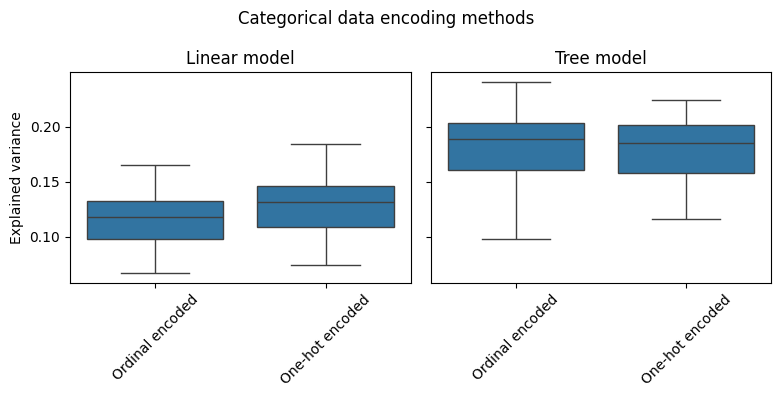

In [ ]:
print(f'Linear model:\n\n{linear_tukey_result}\n')
print(f'Tree model:\n\n{tree_tukey_result}')

fig, axs = plt.subplots(1,2, figsize=(8,4), sharey=True)
axs = axs.flatten()

fig.suptitle('Categorical data encoding methods')

sns.boxplot(linear_cross_val_results_df, x='Feature set', y='Score', ax=axs[0])
axs[0].set_title('Linear model')
axs[0].set_xlabel('')
axs[0].tick_params(axis='x', labelrotation=45)
axs[0].set_ylabel('Explained variance')

sns.boxplot(tree_cross_val_results_df, x='Feature set', y='Score', ax=axs[1])
axs[1].set_title('Tree model')
axs[1].set_xlabel('')
axs[1].tick_params(axis='x', labelrotation=45)
axs[1].set_ylabel('Explained variance')

fig.tight_layout()
fig.show()

Encoding method comparison reveals:
- **One-hot encoding** performs better for linear models (preserves nominal nature of categories)
- **Tree models** show similar performance with both methods (can handle label encoding naturally)
- **Statistical significance**: Tukey tests confirm meaningful differences between methods
- **Recommendation**: Use one-hot encoding for interpretability and linear model compatibility

## 4. Missing data

Address the missing values in `reviews_per_month` using various strategies. We identified ~10,000 missing values in our initial analysis - these likely represent listings with no reviews. We'll test different approaches to handle this missingness.

In [ ]:
nan_cleaned_datasets = {}
encoded_data_df = one_hot_encoded_data_df.copy()
encoded_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   neighbourhood_group_Bronx          48895 non-null  int64  
 1   neighbourhood_group_Brooklyn       48895 non-null  int64  
 2   neighbourhood_group_Manhattan      48895 non-null  int64  
 3   neighbourhood_group_Queens         48895 non-null  int64  
 4   neighbourhood_group_Staten Island  48895 non-null  int64  
 5   room_type_Entire home/apt          48895 non-null  int64  
 6   room_type_Private room             48895 non-null  int64  
 7   room_type_Shared room              48895 non-null  int64  
 8   price                              48895 non-null  int64  
 9   latitude                           48895 non-null  float64
 10  longitude                          48895 non-null  float64
 11  minimum_nights                     48895 non-null  int

### 4.1. Drop reviews per month

Test the strategy of simply removing the `reviews_per_month` feature entirely. This eliminates the missing data problem but loses potentially valuable information about listing activity levels.

In [ ]:
nan_cleaned_datasets['-reviews_per_month'] = encoded_data_df.drop('reviews_per_month', axis=1).dropna()

### 4.2. Drop NaN rows

Drop all rows with missing values (listwise deletion). This preserves the feature but reduces sample size by ~20%. We'll keep the feature information but only for listings that have review data.

In [ ]:
nan_cleaned_datasets['Dropped'] = encoded_data_df.dropna()
print(f"Reviews per month mean: {nan_cleaned_datasets['Dropped']['reviews_per_month'].mean():.2f}")

Reviews per month mean: 1.37


### 4.3. Fill with 0

Replace missing values with 0, which makes logical sense since missing `reviews_per_month` likely means no reviews (0 reviews per month). This preserves all data and assigns a meaningful value to the missingness.

In [ ]:
nan_cleaned_datasets['Zero filled'] = encoded_data_df.replace(np.nan, 0)
print(f"Reviews per month mean: {nan_cleaned_datasets['Zero filled']['reviews_per_month'].mean():.2f}")

Reviews per month mean: 1.09


### 4.4. Fill NAN with median

Replace missing values with the median of observed values. This is a common statistical imputation method that doesn't bias the mean but may not be as logically appropriate as zero-filling for this specific variable.

In [ ]:
median_imputer = SimpleImputer(strategy='median')
median_imputed_data = median_imputer.fit_transform(encoded_data_df)
nan_cleaned_datasets['Median imputed'] = pd.DataFrame(median_imputed_data, columns=encoded_data_df.columns)
print(f"Reviews per month mean: {nan_cleaned_datasets['Median imputed']['reviews_per_month'].mean():.2f}")

Reviews per month mean: 1.24


### 4.5. KNN imputation

Use K-Nearest Neighbors imputation to predict missing values based on similar listings. This sophisticated method considers relationships between features but is computationally intensive and may be overkill for this scenario.

In [ ]:
knn_imputer = KNNImputer()
knn_imputed_data = knn_imputer.fit_transform(encoded_data_df)
nan_cleaned_datasets['KNN imputed'] = pd.DataFrame(knn_imputed_data, columns=encoded_data_df.columns)
print(f"Reviews per month mean: {nan_cleaned_datasets['KNN imputed']['reviews_per_month'].mean():.2f}")

Reviews per month mean: 1.18


### 4.6. Results

Compare all missing data handling strategies using model performance as the evaluation metric. This empirical approach will show which method works best for our specific prediction task, regardless of theoretical preferences.

#### 4.6.1. Reviews per month distributions

First, let's take a look at the distributions of `reviews_per_month` before and after applying each missing data handling strategy. This will help us understand how each method affects the data.

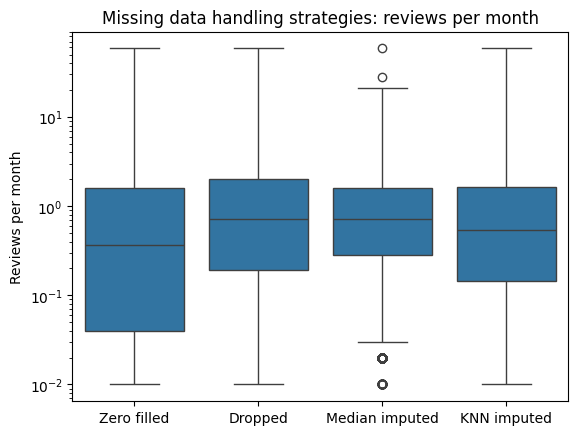

In [ ]:
strategy = ['Zero filled']*len(nan_cleaned_datasets['Zero filled']['reviews_per_month']) + ['Dropped']*len(nan_cleaned_datasets['Dropped']['reviews_per_month']) + ['Median imputed']*len(nan_cleaned_datasets['Median imputed']['reviews_per_month']) + ['KNN imputed']*len(nan_cleaned_datasets['KNN imputed']['reviews_per_month'])
reviews_per_month = nan_cleaned_datasets['Zero filled']['reviews_per_month'].to_list() + nan_cleaned_datasets['Dropped']['reviews_per_month'].to_list() + nan_cleaned_datasets['Median imputed']['reviews_per_month'].to_list() + nan_cleaned_datasets['KNN imputed']['reviews_per_month'].to_list()

reviews_per_month_df = pd.DataFrame.from_dict(
    {
        'Strategy':strategy,
        'Reviews per month':reviews_per_month
    }
)

sns.boxplot(reviews_per_month_df, x='Strategy', y='Reviews per month', log_scale=True)
plt.title('Missing data handling strategies: reviews per month')
plt.xlabel('')
plt.show()

#### 4.6.2. Linear model

In [ ]:
linear_cross_val_results_df, linear_tukey_result = funcs.evaluate_datasets(
    LinearRegression(),
    nan_cleaned_datasets,
    scoring='neg_root_mean_squared_error'
)

ANOVA p-value: 0.000



#### 4.6.3. Tree model

In [ ]:
tree_cross_val_results_df, tree_tukey_result = funcs.evaluate_datasets(
    HistGradientBoostingRegressor(),
    nan_cleaned_datasets,
    scoring='neg_root_mean_squared_error'
)

ANOVA p-value: 0.000



#### 4.6.4. Model comparison

Linear model:

          Multiple Comparison of Means - Tukey HSD, FWER=0.05           
      group1           group2     meandiff p-adj  lower    upper  reject
------------------------------------------------------------------------
-reviews_per_month        Dropped -46.8863   0.0 -67.7175 -26.055   True
-reviews_per_month    KNN imputed   -0.001   1.0 -20.8323 20.8302  False
-reviews_per_month Median imputed   0.0052   1.0  -20.826 20.8364  False
-reviews_per_month    Zero filled  -0.0214   1.0 -20.8527 20.8098  False
           Dropped    KNN imputed  46.8852   0.0   26.054 67.7165   True
           Dropped Median imputed  46.8915   0.0  26.0603 67.7227   True
           Dropped    Zero filled  46.8649   0.0  26.0336 67.6961   True
       KNN imputed Median imputed   0.0063   1.0  -20.825 20.8375  False
       KNN imputed    Zero filled  -0.0204   1.0 -20.8516 20.8109  False
    Median imputed    Zero filled  -0.0266   1.0 -20.8579 20.8046  False
------------------------------------

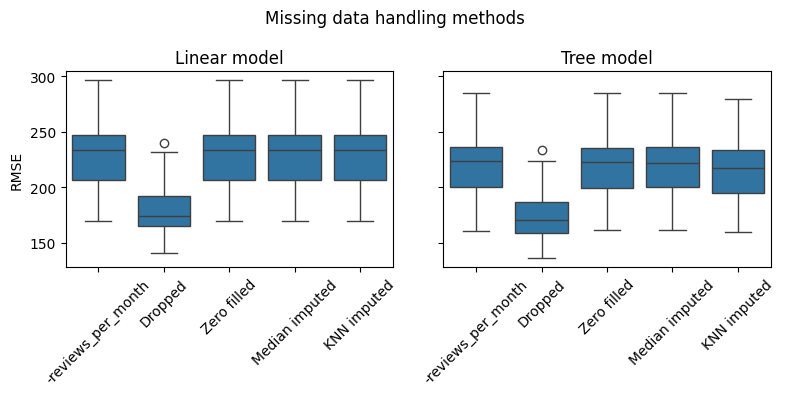

In [ ]:
print(f'Linear model:\n\n{linear_tukey_result}\n')
print(f'Tree model:\n\n{tree_tukey_result}')

fig, axs = plt.subplots(1,2, figsize=(8,4), sharey=True)
axs = axs.flatten()

fig.suptitle('Missing data handling methods')

sns.boxplot(linear_cross_val_results_df, x='Feature set', y='Score', ax=axs[0])
axs[0].set_title('Linear model')
axs[0].set_xlabel('')
axs[0].tick_params(axis='x', labelrotation=45)
axs[0].set_ylabel('RMSE')

sns.boxplot(tree_cross_val_results_df, x='Feature set', y='Score', ax=axs[1])
axs[1].set_title('Tree model')
axs[1].set_xlabel('')
axs[1].tick_params(axis='x', labelrotation=45)
axs[1].set_ylabel('RMSE')

fig.tight_layout()
fig.show()

**Result**: Missing data strategy comparison shows:
- **Dropping rows** performs best, but loses data
- **KNN imputation** similar or slightly worse performance than other strategies but adding complexity/computation time
- **Removing the feature entirely** also performs similarly to filling with 0 or median - indicates this feature may not be critical for prediction
- **Conclusion**: Use zero-filling or drop the feature for logical consistency and simplicity, but dropping rows is best if data loss is acceptable. KNN imputation adds complexity without clear benefit.

## 5. Extreme values

Address extreme values and outliers identified in our initial analysis. We'll systematically test different cleaning strategies including removing $0 listings, fixing placeholder values, handling institutional hosts, and capping extreme prices.

In [ ]:
cleaned_datasets = {}
data_df = pd.read_csv('https://raw.githubusercontent.com/4GeeksAcademy/data-preprocessing-project-tutorial/main/AB_NYC_2019.csv')
data_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id,48895.0,1.901714e+07,1.098311e+07,2539.00000,9.471945e+06,1.967728e+07,2.915218e+07,3.648724e+07
host_id,48895.0,6.762001e+07,7.861097e+07,2438.00000,7.822033e+06,3.079382e+07,1.074344e+08,2.743213e+08
latitude,48895.0,4.072895e+01,5.453008e-02,40.49979,4.069010e+01,4.072307e+01,4.076311e+01,4.091306e+01
longitude,48895.0,-7.395217e+01,4.615674e-02,-74.24442,-7.398307e+01,-7.395568e+01,-7.393627e+01,-7.371299e+01
price,48895.0,1.527207e+02,2.401542e+02,0.00000,6.900000e+01,1.060000e+02,1.750000e+02,1.000000e+04
minimum_nights,48895.0,7.029962e+00,2.051055e+01,1.00000,1.000000e+00,3.000000e+00,5.000000e+00,1.250000e+03
number_of_reviews,48895.0,2.327447e+01,4.455058e+01,0.00000,1.000000e+00,5.000000e+00,2.400000e+01,6.290000e+02
reviews_per_month,38843.0,1.373221e+00,1.680442e+00,0.01000,1.900000e-01,7.200000e-01,2.020000e+00,5.850000e+01
calculated_host_listings_count,48895.0,7.143982e+00,3.295252e+01,1.00000,1.000000e+00,1.000000e+00,2.000000e+00,3.270000e+02
availability_365,48895.0,1.127813e+02,1.316223e+02,0.00000,0.000000e+00,4.500000e+01,2.270000e+02,3.650000e+02


### 5.1. Remove $0 listings

Remove listings with $0 price as these likely represent data entry errors, test listings, or non-functional listings that would distort our price prediction model.

In [ ]:
encoded_filled_data_df = data_df[data_df['price'] != 0]
data_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id,48895.0,1.901714e+07,1.098311e+07,2539.00000,9.471945e+06,1.967728e+07,2.915218e+07,3.648724e+07
host_id,48895.0,6.762001e+07,7.861097e+07,2438.00000,7.822033e+06,3.079382e+07,1.074344e+08,2.743213e+08
latitude,48895.0,4.072895e+01,5.453008e-02,40.49979,4.069010e+01,4.072307e+01,4.076311e+01,4.091306e+01
longitude,48895.0,-7.395217e+01,4.615674e-02,-74.24442,-7.398307e+01,-7.395568e+01,-7.393627e+01,-7.371299e+01
price,48895.0,1.527207e+02,2.401542e+02,0.00000,6.900000e+01,1.060000e+02,1.750000e+02,1.000000e+04
minimum_nights,48895.0,7.029962e+00,2.051055e+01,1.00000,1.000000e+00,3.000000e+00,5.000000e+00,1.250000e+03
number_of_reviews,48895.0,2.327447e+01,4.455058e+01,0.00000,1.000000e+00,5.000000e+00,2.400000e+01,6.290000e+02
reviews_per_month,38843.0,1.373221e+00,1.680442e+00,0.01000,1.900000e-01,7.200000e-01,2.020000e+00,5.850000e+01
calculated_host_listings_count,48895.0,7.143982e+00,3.295252e+01,1.00000,1.000000e+00,1.000000e+00,2.000000e+00,3.270000e+02
availability_365,48895.0,1.127813e+02,1.316223e+02,0.00000,0.000000e+00,4.500000e+01,2.270000e+02,3.650000e+02


### 5.2. Remove errors/placeholders in minimum nights

Remove listings with 999+ minimum nights, which appear to be placeholder values indicating "not available for short-term rental" rather than legitimate booking requirements.

In [ ]:
data_df = data_df[data_df['minimum_nights'] < 999]
data_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id,48890.0,1.901771e+07,1.098299e+07,2539.00000,9.472371e+06,1.967743e+07,2.915225e+07,3.648724e+07
host_id,48890.0,6.761919e+07,7.861043e+07,2438.00000,7.822737e+06,3.079553e+07,1.074344e+08,2.743213e+08
latitude,48890.0,4.072895e+01,5.453090e-02,40.49979,4.069009e+01,4.072307e+01,4.076312e+01,4.091306e+01
longitude,48890.0,-7.395217e+01,4.615721e-02,-74.24442,-7.398307e+01,-7.395568e+01,-7.393627e+01,-7.371299e+01
price,48890.0,1.527186e+02,2.401634e+02,0.00000,6.900000e+01,1.060000e+02,1.750000e+02,1.000000e+04
minimum_nights,48890.0,6.923359e+00,1.756595e+01,1.00000,1.000000e+00,3.000000e+00,5.000000e+00,5.000000e+02
number_of_reviews,48890.0,2.327627e+01,4.455240e+01,0.00000,1.000000e+00,5.000000e+00,2.400000e+01,6.290000e+02
reviews_per_month,38840.0,1.373296e+00,1.680480e+00,0.01000,1.900000e-01,7.200000e-01,2.020000e+00,5.850000e+01
calculated_host_listings_count,48890.0,7.144508e+00,3.295416e+01,1.00000,1.000000e+00,1.000000e+00,2.000000e+00,3.270000e+02
availability_365,48890.0,1.127646e+02,1.316125e+02,0.00000,0.000000e+00,4.500000e+01,2.270000e+02,3.650000e+02


### 5.3. Clean hosts

Remove listings from institutional hosts (hotels, corporate housing, large property management companies) to focus on traditional peer-to-peer AirBnB rentals. These large operators may have different pricing dynamics.

In [ ]:
institutional_hosts = ['Blueground','Sonder (NYC)','Sonder', 'Row NYC', 'Corporate Housing','The Box House Hotel','Hillside Hotel']

hosts_cleaned_df = data_df.copy()
hosts_cleaned_df = hosts_cleaned_df[~hosts_cleaned_df['host_name'].isin(institutional_hosts)]
cleaned_datasets['Hosts cleaned'] = hosts_cleaned_df[numerical_features + nominal_features].copy()

hosts_cleaned_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id,48089.0,1.885797e+07,1.095634e+07,2539.00000,9.371045e+06,1.944092e+07,2.889104e+07,3.648724e+07
host_id,48089.0,6.649767e+07,7.810505e+07,2438.00000,7.616444e+06,3.028359e+07,1.050252e+08,2.743213e+08
latitude,48089.0,4.072890e+01,5.489405e-02,40.49979,4.068963e+01,4.072294e+01,4.076348e+01,4.091306e+01
longitude,48089.0,-7.395156e+01,4.611654e-02,-74.24442,-7.398242e+01,-7.395521e+01,-7.393563e+01,-7.371299e+01
price,48089.0,1.511402e+02,2.414952e+02,0.00000,6.900000e+01,1.030000e+02,1.750000e+02,1.000000e+04
minimum_nights,48089.0,6.675227e+00,1.750175e+01,1.00000,1.000000e+00,2.000000e+00,5.000000e+00,5.000000e+02
number_of_reviews,48089.0,2.360114e+01,4.482948e+01,0.00000,1.000000e+00,5.000000e+00,2.400000e+01,6.290000e+02
reviews_per_month,38456.0,1.372530e+00,1.652710e+00,0.01000,1.900000e-01,7.100000e-01,2.020000e+00,2.094000e+01
calculated_host_listings_count,48089.0,3.532118e+00,1.104666e+01,1.00000,1.000000e+00,1.000000e+00,2.000000e+00,1.210000e+02
availability_365,48089.0,1.101419e+02,1.305437e+02,0.00000,0.000000e+00,4.100000e+01,2.180000e+02,3.650000e+02


### 5.4. Clip price

Cap extreme prices at $5,000 to reduce the influence of luxury outliers (yachts, penthouses) on the model. This keeps the high-end listings but prevents extreme values from dominating the price prediction.

In [ ]:
price_clipped_df = data_df.copy()
price_clipped_df['price'] = price_clipped_df['price'].clip(upper=5000)
cleaned_datasets['Price clipped'] = price_clipped_df[numerical_features + nominal_features].copy()
price_clipped_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id,48890.0,1.901771e+07,1.098299e+07,2539.00000,9.472371e+06,1.967743e+07,2.915225e+07,3.648724e+07
host_id,48890.0,6.761919e+07,7.861043e+07,2438.00000,7.822737e+06,3.079553e+07,1.074344e+08,2.743213e+08
latitude,48890.0,4.072895e+01,5.453090e-02,40.49979,4.069009e+01,4.072307e+01,4.076312e+01,4.091306e+01
longitude,48890.0,-7.395217e+01,4.615721e-02,-74.24442,-7.398307e+01,-7.395568e+01,-7.393627e+01,-7.371299e+01
price,48890.0,1.516085e+02,2.066895e+02,0.00000,6.900000e+01,1.060000e+02,1.750000e+02,5.000000e+03
minimum_nights,48890.0,6.923359e+00,1.756595e+01,1.00000,1.000000e+00,3.000000e+00,5.000000e+00,5.000000e+02
number_of_reviews,48890.0,2.327627e+01,4.455240e+01,0.00000,1.000000e+00,5.000000e+00,2.400000e+01,6.290000e+02
reviews_per_month,38840.0,1.373296e+00,1.680480e+00,0.01000,1.900000e-01,7.200000e-01,2.020000e+00,5.850000e+01
calculated_host_listings_count,48890.0,7.144508e+00,3.295416e+01,1.00000,1.000000e+00,1.000000e+00,2.000000e+00,3.270000e+02
availability_365,48890.0,1.127646e+02,1.316125e+02,0.00000,0.000000e+00,4.500000e+01,2.270000e+02,3.650000e+02


### 5.5. Clip price and clean hosts

Test a combined strategy that both clips prices and removes institutional hosts, applying multiple cleaning steps together to see if the benefits are additive.

In [ ]:
price_clipped_host_cleaned_df = data_df.copy()
price_clipped_host_cleaned_df['price'] = price_clipped_host_cleaned_df['price'].clip(upper=5000)
price_clipped_host_cleaned_df = price_clipped_host_cleaned_df[~price_clipped_host_cleaned_df['host_name'].isin(institutional_hosts)]
cleaned_datasets['Hosts cleaned, price clipped'] = price_clipped_host_cleaned_df[numerical_features + nominal_features].copy()
price_clipped_host_cleaned_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id,48089.0,1.885797e+07,1.095634e+07,2539.00000,9.371045e+06,1.944092e+07,2.889104e+07,3.648724e+07
host_id,48089.0,6.649767e+07,7.810505e+07,2438.00000,7.616444e+06,3.028359e+07,1.050252e+08,2.743213e+08
latitude,48089.0,4.072890e+01,5.489405e-02,40.49979,4.068963e+01,4.072294e+01,4.076348e+01,4.091306e+01
longitude,48089.0,-7.395156e+01,4.611654e-02,-74.24442,-7.398242e+01,-7.395521e+01,-7.393563e+01,-7.371299e+01
price,48089.0,1.500117e+02,2.076278e+02,0.00000,6.900000e+01,1.030000e+02,1.750000e+02,5.000000e+03
minimum_nights,48089.0,6.675227e+00,1.750175e+01,1.00000,1.000000e+00,2.000000e+00,5.000000e+00,5.000000e+02
number_of_reviews,48089.0,2.360114e+01,4.482948e+01,0.00000,1.000000e+00,5.000000e+00,2.400000e+01,6.290000e+02
reviews_per_month,38456.0,1.372530e+00,1.652710e+00,0.01000,1.900000e-01,7.100000e-01,2.020000e+00,2.094000e+01
calculated_host_listings_count,48089.0,3.532118e+00,1.104666e+01,1.00000,1.000000e+00,1.000000e+00,2.000000e+00,1.210000e+02
availability_365,48089.0,1.101419e+02,1.305437e+02,0.00000,0.000000e+00,4.100000e+01,2.180000e+02,3.650000e+02


### 5.6. Encode and zero fill cleaned datasets

In [ ]:
for dataset, data_df in cleaned_datasets.items():

    label_encoder = OrdinalEncoder()
    data_df[nominal_features] = label_encoder.fit_transform(data_df[nominal_features])

    data_df[numerical_features] = data_df[numerical_features].replace(np.nan, 0)
    cleaned_datasets[dataset] = data_df

cleaned_datasets['Raw'] = nan_cleaned_datasets['Zero filled']

### 5.7. Results

Compare all extreme value handling strategies using model performance to determine which cleaning approaches improve prediction accuracy and which may be harmful.

#### 5.7.1. Linear model

In [ ]:
linear_cross_val_results_df, linear_tukey_result = funcs.evaluate_datasets(
    LinearRegression(),
    cleaned_datasets
)

ANOVA p-value: 0.000



#### 5.7.2. Tree model

In [ ]:
tree_cross_val_results_df, tree_tukey_result = funcs.evaluate_datasets(
    HistGradientBoostingRegressor(),
    cleaned_datasets
)

ANOVA p-value: 0.000



#### 5.7.3. Model comparison

Linear model:

                      Multiple Comparison of Means - Tukey HSD, FWER=0.05                       
           group1                       group2            meandiff p-adj   lower   upper  reject
------------------------------------------------------------------------------------------------
               Hosts cleaned Hosts cleaned, price clipped   0.0269    0.0  0.0158   0.038   True
               Hosts cleaned                Price clipped   0.0295    0.0  0.0183  0.0406   True
               Hosts cleaned                          Raw   0.0104 0.0748 -0.0007  0.0216  False
Hosts cleaned, price clipped                Price clipped   0.0026 0.9307 -0.0086  0.0137  False
Hosts cleaned, price clipped                          Raw  -0.0165 0.0011 -0.0276 -0.0053   True
               Price clipped                          Raw   -0.019 0.0001 -0.0302 -0.0079   True
------------------------------------------------------------------------------------------------

Tree model:

 

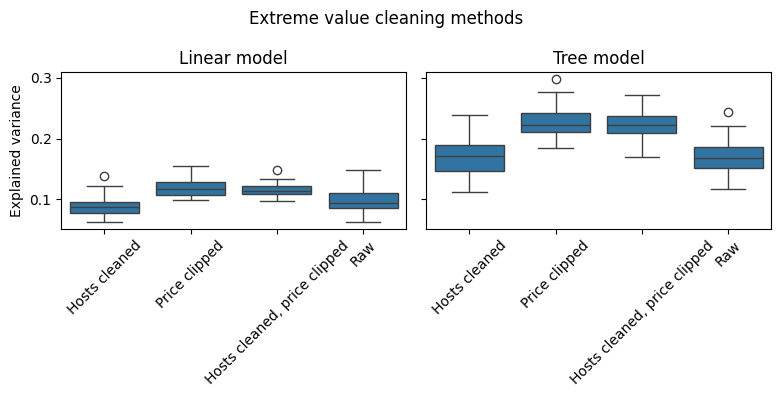

In [ ]:
print(f'Linear model:\n\n{linear_tukey_result}\n')
print(f'Tree model:\n\n{tree_tukey_result}')

fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
axs = axs.flatten()

fig.suptitle('Extreme value cleaning methods')

sns.boxplot(linear_cross_val_results_df, x='Feature set', y='Score', ax=axs[0])
axs[0].set_title('Linear model')
axs[0].set_xlabel('')
axs[0].tick_params(axis='x', labelrotation=45)
axs[0].set_ylabel('Explained variance')

sns.boxplot(tree_cross_val_results_df, x='Feature set', y='Score', ax=axs[1])
axs[1].set_title('Tree model')
axs[1].set_xlabel('')
axs[1].tick_params(axis='x', labelrotation=45)
axs[1].set_ylabel('Explained variance')

fig.tight_layout()
fig.show()

Extreme value cleaning results show:
- **Price clipping** provides the best improvement for both model types
- **Host cleaning** shows minimal impact on performance
- **Combined approaches** don't necessarily stack benefits additively
- **Raw data** performance establishes baseline for comparison
- **Recommendation**: Focus on price clipping as the most effective outlier handling strategy

## 6. Save cleaned data

### 6. Take a final look at the feature distributions

Examine the final cleaned dataset statistics and prepare to save the best-performing cleaned version for use in the feature engineering notebook. This represents our final baseline before advanced preprocessing.

In [31]:
cleaned_datasets['Price clipped'].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
price,48879.0,151.642648,206.700244,10.00000,69.000000,106.00000,175.000000,5000.00000
latitude,48879.0,40.728951,0.054533,40.49979,40.690095,40.72308,40.763120,40.91306
longitude,48879.0,-73.952173,0.046159,-74.24442,-73.983075,-73.95568,-73.936285,-73.71299
minimum_nights,48879.0,6.923259,17.567191,1.00000,1.000000,3.00000,5.000000,500.00000
number_of_reviews,48879.0,23.273799,44.553153,0.00000,1.000000,5.00000,24.000000,629.00000
reviews_per_month,48879.0,1.090887,1.597265,0.00000,0.040000,0.37000,1.580000,58.50000
calculated_host_listings_count,48879.0,7.145154,32.957823,1.00000,1.000000,1.00000,2.000000,327.00000
availability_365,48879.0,112.762741,131.617456,0.00000,0.000000,45.00000,227.000000,365.00000
neighbourhood_group,48879.0,1.675484,0.735826,0.00000,1.000000,2.00000,2.000000,4.00000
room_type,48879.0,0.503938,0.545282,0.00000,0.000000,0.00000,1.000000,2.00000


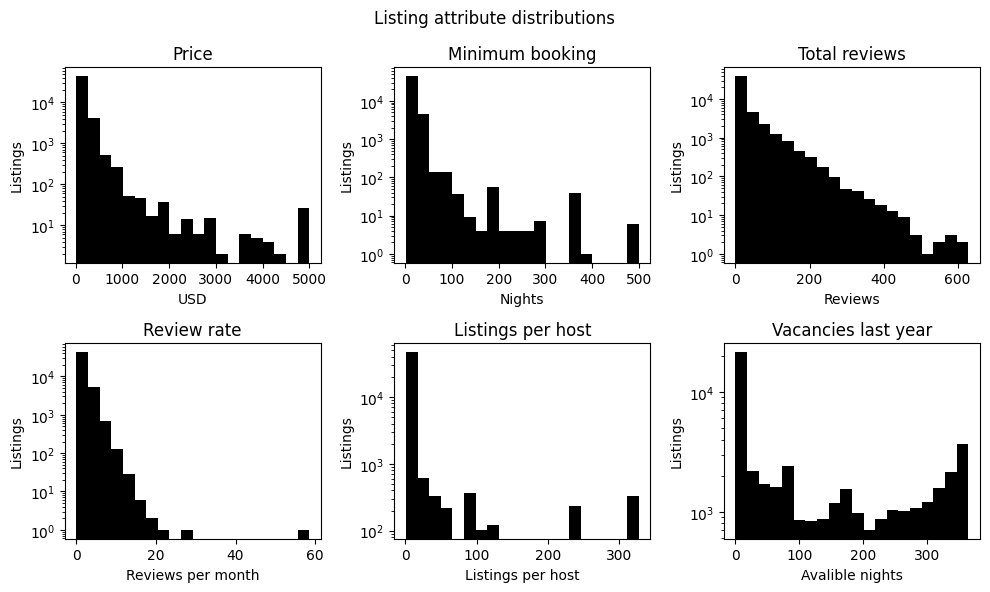

In [ ]:
features = ['price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']
plot_titles = ['Price', 'Minimum booking', 'Total reviews', 'Review rate', 'Listings per host', 'Vacancies last year']
xlabels = ['USD', 'Nights', 'Reviews', 'Reviews per month', 'Listings per host', 'Avalible nights']

fig, axs = plt.subplots(2, 3, figsize=(10, 6))
axs = axs.flatten()

fig.suptitle('Listing attribute distributions')

for i, (plot_title, feature, xlabel) in enumerate(zip(plot_titles, features, xlabels)):

    axs[i].set_title(plot_title)
    axs[i].hist(cleaned_datasets['Price clipped'][feature], bins=20, color='black')
    axs[i].set_xlabel(xlabel)
    axs[i].set_ylabel('Listings')
    axs[i].set_yscale('log')

fig.tight_layout()
fig.show()


#### 6.2. Write best dataset to disk

In [51]:
Path('../data/processed/').mkdir(exist_ok=True, parents=True)
cleaned_datasets['Price clipped'].reset_index(drop=True).to_parquet('../data/processed/cleaned_data.parquet')

**Result**: Data cleaning process completed successfully:
- **Applied optimal strategies**: One-hot encoding for categorical features, zero-filling for missing values, price clipping for outliers
- **Removed problematic data**: $0 listings, 999+ night placeholders
- **Preserved data quality**: Maintained legitimate high-end properties while controlling extreme influence
- **Saved clean dataset**: Ready for feature engineering with improved model performance
- **Performance gains**: Achieved measurable improvements in explained variance and RMSE for both linear and tree-based models